In [69]:
#Our Github is at https://github.com/paulLieber98/ucla-doordash-proj
#https://www.kaggle.com/datasets/dharun4772/doordash-eta-prediction/data

In [70]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore")

In [71]:
#read the dataset
df = pd.read_csv("historical_data.csv")
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0


In [72]:
#do some exploratory data analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [73]:
df_without_strings = df.drop(["created_at","actual_delivery_time","store_primary_category"],axis=1)
df_without_strings.corr()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
market_id,1.000000,0.017301,-0.021895,-0.006855,-0.016237,0.002557,-0.000150,-0.004921,0.069752,0.060488,0.063754,-0.053241,0.006597
store_id,0.017301,1.000000,0.019554,-0.008796,-0.013370,-0.012727,-0.009128,-0.018661,-0.023141,-0.023245,-0.020348,0.017469,0.001953
order_protocol,-0.021895,0.019554,1.000000,0.008790,-0.053623,-0.023342,-0.045421,-0.090960,0.145022,0.149584,0.134895,-0.678222,-0.008326
total_items,-0.006855,-0.008796,0.008790,1.000000,0.558067,0.763912,-0.393149,-0.058233,0.031732,0.028602,0.034380,-0.023643,0.004692
subtotal,-0.016237,-0.013370,-0.053623,0.558067,1.000000,0.681101,0.037038,0.505547,0.130831,0.125566,0.130106,0.039043,0.034665
num_distinct_items,0.002557,-0.012727,-0.023342,0.763912,0.681101,1.000000,-0.448739,0.041871,0.065943,0.060638,0.067800,0.003507,0.022693
min_item_price,-0.000150,-0.009128,-0.045421,-0.393149,0.037038,-0.448739,1.000000,0.545484,0.042368,0.043881,0.041002,0.053073,0.003373
max_item_price,-0.004921,-0.018661,-0.090960,-0.058233,0.505547,0.041871,0.545484,1.000000,0.133113,0.131005,0.130676,0.085287,0.026591
total_onshift_dashers,0.069752,-0.023141,0.145022,0.031732,0.130831,0.065943,0.042368,0.133113,1.000000,0.943789,0.936122,-0.185650,0.045925
total_busy_dashers,0.060488,-0.023245,0.149584,0.028602,0.125566,0.060638,0.043881,0.131005,0.943789,1.000000,0.932913,-0.191811,0.044504


Text(0.5, 1.0, 'Subtotal over Total Items')

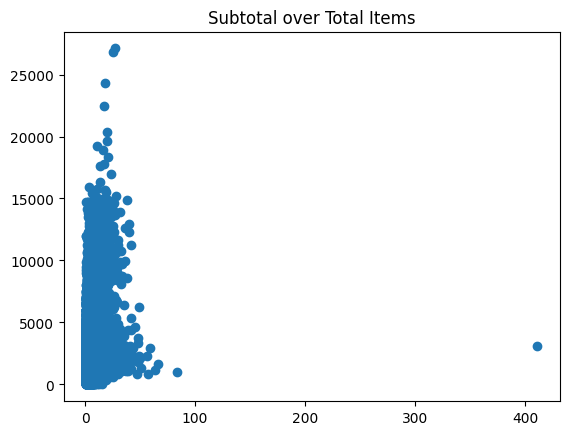

In [74]:

plt.scatter(df["total_items"],df["subtotal"])
plt.title("Subtotal over Total Items")


In [75]:
#drop the outlier and remove all rows where there is missingness in the subtotal
df = df[df["total_items"]<300]
df = df[df["subtotal"].isnull() == False]


Text(0.5, 1.0, 'Inertia over number of clusters')

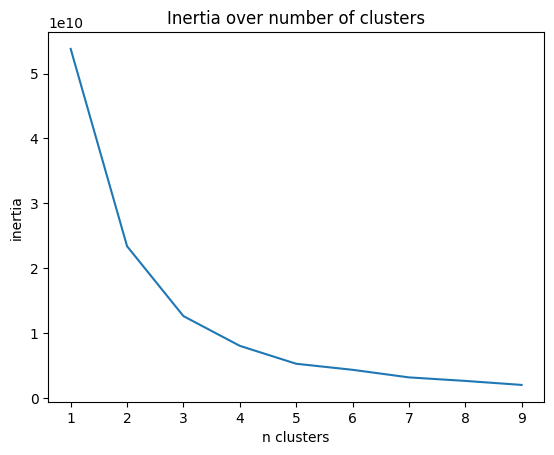

In [76]:
#clustering using total items and max item price


#plotting elbow curve to find the best number of clusters
from sklearn.cluster import KMeans
num = range(1,10)
inertias = []
for i in num:
  k_means_cluster = KMeans(n_clusters = i)
  k_means_cluster.fit(df[["total_items","min_item_price"]])
  inertias.append(k_means_cluster.inertia_)

plt.plot(num,inertias)
plt.xlabel("n clusters")
plt.ylabel("inertia")
plt.title("Inertia over number of clusters")




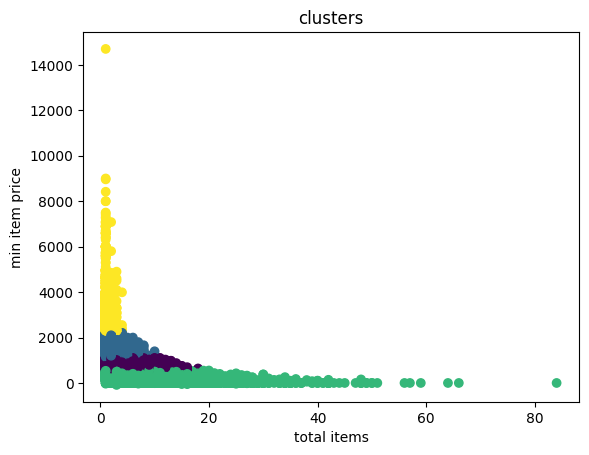

In [77]:
#clustering using n_clusters = 4
k_means_cluster = KMeans(n_clusters = 4)
k_means_cluster.fit(df[["total_items","min_item_price"]].dropna())
results = k_means_cluster.predict(df[["total_items","min_item_price"]])
plt.scatter(df[["total_items"]],df[["min_item_price"]], c=results)
plt.xlabel("total items")
plt.ylabel("min item price")
plt.title("clusters")

#augment data using the clusters
df["clusters"] = results.astype(str)

In [78]:
#train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
y_data = df["subtotal"]

X_train,X_test,y_train,y_test = train_test_split(df,y_data,random_state = 100, test_size = 0.2)


In [79]:
from sklearn.impute import SimpleImputer

#Imputation for X_train
imputer_num = SimpleImputer(strategy = "median").set_output(transform="pandas")
values_num = imputer_num.fit_transform(X_train[["market_id","store_id","order_protocol","total_items","num_distinct_items","min_item_price","max_item_price","total_onshift_dashers","total_busy_dashers","total_outstanding_orders","estimated_order_place_duration","estimated_store_to_consumer_driving_duration"]])
imputer_cat = SimpleImputer(strategy = "constant", fill_value = "unknown").set_output(transform="pandas")
values_cat = imputer_cat.fit_transform(X_train[["created_at","actual_delivery_time","store_primary_category","clusters"]])
X_train = pd.concat([values_num,values_cat],axis=1)
X_train= X_train.dropna()

#imputation for X_test
imputer_num = SimpleImputer(strategy = "median").set_output(transform="pandas")
values_num = imputer_num.fit_transform(X_test[["market_id","store_id","order_protocol","total_items","num_distinct_items","min_item_price","max_item_price","total_onshift_dashers","total_busy_dashers","total_outstanding_orders","estimated_order_place_duration","estimated_store_to_consumer_driving_duration"]])
imputer_cat = SimpleImputer(strategy = "constant", fill_value = "unknown").set_output(transform="pandas")
values_cat = imputer_cat.fit_transform(X_test[["created_at","actual_delivery_time","store_primary_category","clusters"]])
X_test = pd.concat([values_num,values_cat],axis=1)
X_test= X_test.dropna()




In [80]:
#correct all the labels for y_train and y_test
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
y_train = pd.DataFrame(labels.fit_transform(y_train))
labels = LabelEncoder()
y_test = pd.DataFrame(labels.fit_transform(y_test))


In [81]:
#Standardize all the data then use SequentialFeatureSelector to select features
from sklearn.feature_selection import SequentialFeatureSelector
X_train_num = X_train[["order_protocol","total_items","num_distinct_items","min_item_price","max_item_price","total_onshift_dashers","total_busy_dashers","total_outstanding_orders","estimated_order_place_duration","estimated_store_to_consumer_driving_duration"]]
X_test_num = X_test[["order_protocol","total_items","num_distinct_items","min_item_price","max_item_price","total_onshift_dashers","total_busy_dashers","total_outstanding_orders","estimated_order_place_duration","estimated_store_to_consumer_driving_duration"]]

standardizer = StandardScaler().set_output(transform = "pandas")
X_train_num = standardizer.fit_transform(X_train_num)

standardizer = StandardScaler().set_output(transform = "pandas")
X_test_num = standardizer.fit_transform(X_test_num)

estimator = LinearRegression()
features = SequentialFeatureSelector(estimator)
features.fit(X_train_num,y_train)
print(features.get_support())








[False  True  True  True  True False False  True False False]


In [82]:
#set the data to the data selected by the SequentialFeatureSelector and one hot encode the categorical data
X_data_categorical_train = X_train[["clusters"]]
X_data_categorical_test = X_test[["clusters"]]

X_data_encoded_categorical_train = pd.get_dummies(X_data_categorical_train)
X_data_encoded_categorical_test = pd.get_dummies(X_data_categorical_test)


standardizer = StandardScaler().set_output(transform="pandas")
X_data_train = X_train_num.drop(["order_protocol","total_busy_dashers","total_outstanding_orders","estimated_order_place_duration","estimated_store_to_consumer_driving_duration"],axis=1)
X_data_test = X_test_num.drop(["order_protocol","total_busy_dashers","total_outstanding_orders","estimated_order_place_duration","estimated_store_to_consumer_driving_duration"],axis=1)
X_data_train = pd.concat([X_data_train,X_data_encoded_categorical_train],axis=1)
X_data_test = pd.concat([X_data_test,X_data_encoded_categorical_test],axis=1)






In [83]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
#XGBoosting regression with cross validation

labels = LabelEncoder()

rates = [0.01,0.1,0.2,0.3,0.5,1]
for rate in rates:
  scores = []
  val = KFold(n_splits=5)
  for i, (train_index, test_index) in enumerate(val.split(X_train)):
      regression = XGBRegressor(max_depth = 6,n_estimators = 100,objective = "reg:linear",learning_rate = rate,verbosity =  0)
      regression.fit(X_data_train.iloc[train_index],pd.DataFrame(labels.fit_transform(y_train.iloc[train_index])))
      scores.append(regression.score(X_data_train.iloc[test_index],y_train.iloc[test_index]))
      y_pred = regression.predict(X_data_train.iloc[test_index])

  print(np.mean(scores))


0.7601097464561463
0.9237493395805358
0.9233398556709289
0.9225233197212219
0.9205268979072571
0.912072503566742


In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#finally test XGBoosting on the test dataset


regression_final = XGBRegressor(max_depth = 6,n_estimators = 100,objective = "reg:linear",learning_rate = 0.2,verbosity =  0,device="cuda")
regression_final.fit(X_data_train,y_train)
prediction = regression_final.predict(X_data_test)
print(mean_squared_error(prediction,y_test))
print(r2_score(prediction,y_test))

420872.21875
0.8223292827606201
